# Import

In [4]:
import scanpy as sc
import anndata as ad
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dadapy.data import Data
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import warnings
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Functions

In [5]:
def compute_ID(adata:ad.AnnData, group:str='all', method:str='2nn', variance_e:float=0.9, sample_size:int=0, n_neighbors:int = 0,
               n_samples:int=10, normalization:bool=True, norm_sum:int=1e6, full_output:bool=False) -> list[float]:

    # Make obs names unique
    adata.obs.index = adata.obs.index.astype(str)
    adata.obs_names_make_unique()
    
    # Normalization
    if normalization == True:
        sc.pp.normalize_total(adata, target_sum=norm_sum)

    # Convert to array matrix
    if not isinstance(adata.X, np.ndarray):
        adata.X = adata.X.toarray()

    
    # Add a obs column to compute ID of all sample if no group is specified
    if group == 'all':
        adata.obs['all'] = ['ID']*len(adata)
    
    # Get obs names and counts
    labels, counts = np.unique(adata.obs[group], return_counts = True)

    # Set default sample_size and n_neighbors
    
    if (sample_size == 0)|(sample_size>counts.min()):
        sample_size = int(0.8*counts.min())
        warnings.warn(f'Warning : Sample size is null or too large. The sample size is thus set as 80% of the minimum number of cells among categories : sample size = {sample_size} ')

    if (n_neighbors == 0)|(n_neighbors>counts.min()):
        n_neighbors = int(0.1*counts.min())
        warnings.warn(f'Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = {n_neighbors} ')

    # Create a list to store the ID
    id_list = []
    
    # Loop over the unique labels
    for label in tqdm(labels, desc='Computing Intrinsic Dimension', total=len(labels)):

        print(f'Computing ID for {group} {label}:')
        
        # Filter data per labels
        data_label = adata[adata.obs[group]==label]

        
        # Compute the ID
         # select method
        if method.lower() == '2nn':
            id_ = id_2nn(data_label, sample_size = sample_size, n_samples = n_samples)
        
        elif method.lower() == 'local_2nn':
            id_ = id_local_2nn(data_label, n_neighbors = n_neighbors, n_samples = n_samples)
            
        elif method.lower() == 'pca':
            id_ = id_pca(data_label,  sample_size = sample_size, n_samples = n_samples, threshold = variance_e)

        elif method.lower() == 'local_pca':
            id_ = id_local_pca(data_label, n_neighbors = n_neighbors, n_samples = n_samples)


        else:
            raise ValueError('Method not implemented')
            
        # Append the ID
        id_list.append(id_)

    # Reshape id_list
    id_array = np.asarray(id_list).reshape(len(labels),n_samples)
        
     # Format the output
    if full_output == False:

        id_mean = np.mean(id_array, axis = 1)
        id_sigma = np.std(id_array, axis = 1)
        id_comb = [id_mean, id_sigma]
        id = pd.DataFrame(id_comb)
        id.columns = labels
        id.index = ['Mean Intrinsic Dimension', 'Standard Deviation']
        
    else:
        
        id = pd.DataFrame(id_array.T, columns = labels)

    #Remove added temporary obs column
    if 'all' in adata.obs.columns :
        adata.obs.drop(columns = ['all'], inplace = True)
    
    return id

In [67]:
def id_2nn(adata, sample_size , n_samples=10):

    # Create empty list of id
    id_samples = []

    # select samples and calculate ID 
    for s in range(n_samples):
        indexes = np.array(adata.obs.index)
        random.shuffle(indexes)
        names=indexes[:sample_size]

        # initialise the "Data" class with the set of coordinates
        data = Data(np.asarray(adata[names,:].X).astype(float)) #astype float to avoid errors in dadapy
        
        # compute the intrinsic dimension using 2nn estimator
        id,error,_ = data.compute_id_2NN()
        id_samples.append(id)
 
    return id_samples

In [68]:
def id_local_2nn(adata, n_neighbors = 0, n_samples = 100):
              
    # Create empty list of id
    id_samples = []

    #extract n_local_measures names of cells
    indexes = np.array(adata.obs.index)
    random.shuffle(indexes)
    cells=indexes[:n_samples]

     # Create nearest neighbors network
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)

    # Find the nearest neighbors for every cell
    data_matrix = adata.X
    neighbors.fit(data_matrix)
    
    for name in tqdm(cells, desc="Processing cells"):
        
        #filter adata 
        root_cell = adata[adata.obs_names == name].X
    
        # Find the nearest neighbors for the specific cell rapresented by 'cell_data'
        indices = neighbors.kneighbors(root_cell, return_distance=False)
        indices = indices.flatten()
        
        # Extract the local neighborhood data
        local_data = adata[indices]
        nnz_genes = np.count_nonzero(local_data.X, axis = 0)>0
        local_data = local_data[:, nnz_genes]

        names = [list(adata.obs_names)[index] for index in indices]
        
         # initialise the "Data" class with the set of coordinates
        data = Data(np.asarray(local_data.X).astype(float)) #astype float to avoid errors in dadapy
        
        # compute the intrinsic dimension using 2nn estimator
        local_id,error,_ = data.compute_id_2NN()
        id_samples.append(local_id)

    return id_samples

In [69]:
def id_local_pca(adata, n_neighbors = 0, n_samples = 100):
              
    # Create empty list of id
    id_samples = []

    #extract n_local_measures names of cells
    indexes = np.array(adata.obs.index)
    random.shuffle(indexes)
    cells=indexes[:n_samples]

     # Create nearest neighbors network
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)

    # Find the nearest neighbors for every cell
    data_matrix = adata.X
    neighbors.fit(data_matrix)
    
    for name in tqdm(cells):

        #filter adata 
        root_cell = adata[adata.obs_names == name].X
    
        # Find the nearest neighbors for the specific cell rapresented by 'cell_data'
        indices = neighbors.kneighbors(root_cell, return_distance=False)
        indices = indices.flatten()
        
        # Extract the local neighborhood data
        local_data = adata[indices]
        nnz_genes = np.count_nonzero(local_data.X, axis = 0)>0
        local_data = local_data[:, nnz_genes]

        names = [list(adata.obs_names)[index] for index in indices]
        
        local_id = d_PCA(local_data, names)
        id_samples.append(local_id)

    return id_samples
    

In [70]:
def d_PCA(Adata, Names, threshold=.9):
    
    X=np.asarray(Adata[Names,:].X)
    
    comp = min(np.shape(X))  
    pca_tot = PCA(n_components=comp)
    pca_tot.fit(X)
    explained=pca_tot.explained_variance_ratio_
    
    for i in range(comp):
        if sum(explained[:i])>threshold:
            break 
    return i

In [71]:
def id_pca(adata, sample_size, n_samples=10,  threshold=.9):
    
    #adata = adata.copy()
    #adata.obs.reset_index(inplace=True,drop=True)

     # Create empty list of id
    id_samples = []

    # select samples and calculate ID 
    for s in tqdm(range(n_samples)):
        indexes = np.array(adata.obs.index)
        random.shuffle(indexes)
        names=indexes[:sample_size]

        # compute the intrinsic dimension using PCA estimator
        id = d_PCA(adata, names, threshold = threshold)
        id_samples.append(id)

    return id_samples


In [72]:
def normalize_plot(y, y_err, max_point = 0, min_point = 0):
    if (max_point == 0)&(min_point == 0):
        max_point = max(y) + y_err[np.argmax(y)]
        min_point = min(y) - y_err[np.argmin(y)]
    y_norm = [(d-min_point)/(max_point-min_point) for d in y]
    y_err_norm = [std/max_point for std in y_err]

    return y_norm, y_err_norm

In [73]:
def rename_clusters(adata, pluripotency):
    pluripotency_rounded = {k: round(v, 2) for k, v in pluripotency.items()}
    replacement_mapping = {j: f'{i+1}' for i, j in enumerate(pluripotency_rounded.keys())}
    adata.obs['pluripotency'] = adata.obs['leiden'].map(pluripotency_rounded)
    adata.obs['leiden'] = adata.obs['leiden'].replace(replacement_mapping)
    return adata, replacement_mapping

In [74]:
def add_pseudotime(adata, pseudotime):
    pseudotime_rounded = {k: round(v, 2) for k, v in pseudotime.items()}
    adata.obs['pseudotime'] = adata.obs['leiden'].map(pseudotime_rounded)
    return adata

In [75]:
def remove_clusters(adata,clusters_to_remove):
    adata = adata[~adata.obs['leiden'].isin(clusters_to_remove)]
    return adata

In [87]:
def preprocess_genes(Adata):
    sc.pp.filter_genes(Adata, min_cells=int(0.01 * len(Adata)))
    coding_genes = np.load('/Users/maddalenastaiano/Desktop/data/cds.npy')
    gene_list = Adata.var.query('index in @coding_genes').index.values.tolist() 
    Adata = Adata[:,gene_list] 
    return  Adata

# NEW version figure 2

In [3]:
adata_fbs=sc.read('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/FBS_IDEAS.h5ad')
adata_a2s=sc.read('/Users/maddalenastaiano/Desktop/notebooks_ID/Notebooks_IDEAS/data_IDEAS/A2S_IDEAS.h5ad')

In [78]:
adata_fbs = preprocess_genes(adata_fbs)
adata_a2s = preprocess_genes(adata_a2s)

In [81]:
print(np.unique(adata_a2s[adata_a2s.obs.replicate=='1'].obs.cluster, return_counts = True),np.unique(adata_a2s[adata_a2s.obs.replicate=='2'].obs.cluster, return_counts = True))

(array(['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5',
       'cluster 6'], dtype=object), array([293,  60, 143, 392, 115, 134])) (array(['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5',
       'cluster 6'], dtype=object), array([415,  62, 156, 351, 129, 158]))


In [83]:
sample_sizeF = 140
sample_sizeA = 60
num_samples = 200

id_fbs_rep1 = compute_ID(adata_fbs[adata_fbs.obs.replicate=='1'], group = 'cluster', method='2nn', sample_size=sample_sizeF, n_samples = num_samples)
id_fbs_rep2 = compute_ID(adata_fbs[adata_fbs.obs.replicate=='2'], group = 'cluster', method='2nn', sample_size=sample_sizeF, n_samples = num_samples)

id_a2s_rep1 = compute_ID(adata_a2s[adata_a2s.obs.replicate=='1'], group = 'cluster', method='2nn', sample_size=sample_sizeA, n_samples = num_samples)
id_a2s_rep2 = compute_ID(adata_a2s[adata_a2s.obs.replicate=='2'], group = 'cluster', method='2nn', sample_size=sample_sizeA, n_samples = num_samples)

/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_8021/1492044056.py:32: UserWarning: Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = 14 
  warnings.warn(f'Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = {n_neighbors} ')
Computing Intrinsic Dimension:   0%|          | 0/5 [00:00<?, ?it/s]

Computing ID for cluster cluster 1:


Computing Intrinsic Dimension:  20%|██        | 1/5 [00:03<00:12,  3.11s/it]

Computing ID for cluster cluster 2:


Computing Intrinsic Dimension:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

Computing ID for cluster cluster 3:


Computing Intrinsic Dimension:  60%|██████    | 3/5 [00:09<00:06,  3.08s/it]

Computing ID for cluster cluster 4:


Computing Intrinsic Dimension:  80%|████████  | 4/5 [00:12<00:03,  3.08s/it]

Computing ID for cluster cluster 5:


Computing Intrinsic Dimension: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_8021/1492044056.py:32: UserWarning: Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = 17 
  warnings.warn(f'Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = {n_neighbors} ')
Computing Intrinsic Dimension:   0%|          | 0/5 [00:00<?, ?it/s]

Computing ID for cluster cluster 1:


Computing Intrinsic Dimension:  20%|██        | 1/5 [00:02<00:11,  2.82s/it]

Computing ID for cluster cluster 2:


Computing Intrinsic Dimension:  40%|████      | 2/5 [00:05<00:08,  2.82s/it]

Computing ID for cluster cluster 3:


Computing Intrinsic Dimension:  60%|██████    | 3/5 [00:08<00:05,  2.80s/it]

Computing ID for cluster cluster 4:


Computing Intrinsic Dimension:  80%|████████  | 4/5 [00:11<00:02,  2.80s/it]

Computing ID for cluster cluster 5:


Computing Intrinsic Dimension: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_8021/1492044056.py:32: UserWarning: Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = 6 
  warnings.warn(f'Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = {n_neighbors} ')
Computing Intrinsic Dimension:   0%|          | 0/6 [00:00<?, ?it/s]

Computing ID for cluster cluster 1:


Computing Intrinsic Dimension:  17%|█▋        | 1/6 [00:01<00:05,  1.10s/it]

Computing ID for cluster cluster 2:


Computing Intrinsic Dimension:  33%|███▎      | 2/6 [00:02<00:04,  1.03s/it]

Computing ID for cluster cluster 3:


Computing Intrinsic Dimension:  50%|█████     | 3/6 [00:03<00:02,  1.01it/s]

Computing ID for cluster cluster 4:


Computing Intrinsic Dimension:  67%|██████▋   | 4/6 [00:04<00:02,  1.13s/it]

Computing ID for cluster cluster 5:


Computing Intrinsic Dimension:  83%|████████▎ | 5/6 [00:05<00:01,  1.09s/it]

Computing ID for cluster cluster 6:


Computing Intrinsic Dimension: 100%|██████████| 6/6 [00:06<00:00,  1.08s/it]
/var/folders/hh/d5yl6z994mzbfn58khq3smpc0000gn/T/ipykernel_8021/1492044056.py:32: UserWarning: Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = 6 
  warnings.warn(f'Warning : Number of neighbors (n_neighbors) is null or too large. n_neighbors is thus set as 10% of the minimum number of cells among categories : n_neighbors = {n_neighbors} ')
Computing Intrinsic Dimension:   0%|          | 0/6 [00:00<?, ?it/s]

Computing ID for cluster cluster 1:


Computing Intrinsic Dimension:  17%|█▋        | 1/6 [00:01<00:05,  1.09s/it]

Computing ID for cluster cluster 2:


Computing Intrinsic Dimension:  33%|███▎      | 2/6 [00:02<00:04,  1.20s/it]

Computing ID for cluster cluster 3:


Computing Intrinsic Dimension:  50%|█████     | 3/6 [00:03<00:03,  1.30s/it]

Computing ID for cluster cluster 4:


Computing Intrinsic Dimension:  67%|██████▋   | 4/6 [00:04<00:02,  1.24s/it]

Computing ID for cluster cluster 5:


Computing Intrinsic Dimension:  83%|████████▎ | 5/6 [00:06<00:01,  1.18s/it]

Computing ID for cluster cluster 6:


Computing Intrinsic Dimension: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


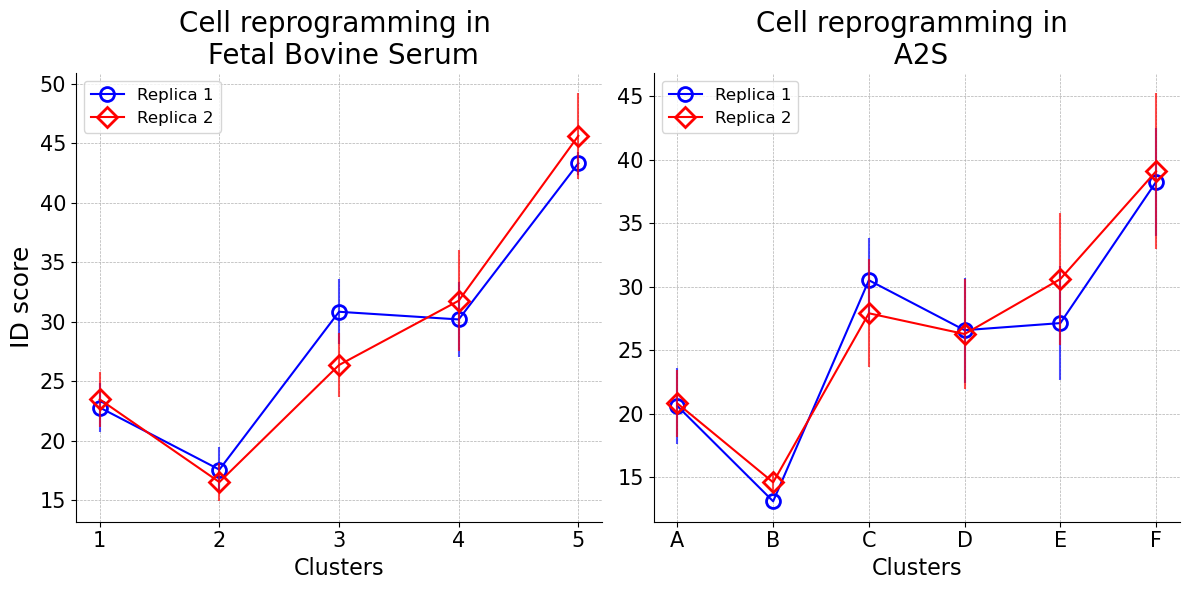

In [89]:
#data to plot
#FBS
col1 = id_fbs_rep1.columns
mean1 = id_fbs_rep1.loc['Mean Intrinsic Dimension']
std1 = id_fbs_rep1.loc['Standard Deviation']
col2 = id_fbs_rep2.columns
mean2 = id_fbs_rep2.loc['Mean Intrinsic Dimension']
std2 = id_fbs_rep2.loc['Standard Deviation']

#A2S
col1_A = id_a2s_rep1.columns
mean1_A = id_a2s_rep1.loc['Mean Intrinsic Dimension']
std1_A = id_a2s_rep1.loc['Standard Deviation']
col2_A = id_a2s_rep2.columns
mean2_A = id_a2s_rep2.loc['Mean Intrinsic Dimension']
std2_A = id_a2s_rep2.loc['Standard Deviation']

#extraxt max and min point for FBS and A2S
all_means = np.concatenate((np.array(mean1),np.array(mean2)))
all_std = np.concatenate((np.array(std1),np.array(std2)))
max_F = max(all_means) + all_std[np.argmax(all_means)]
min_F = min(all_means) - all_std[np.argmin(all_means)]

all_meansA =  np.concatenate((np.array(mean1_A),np.array(mean2_A)))
all_stdA = np.concatenate((np.array(std1_A),np.array(std2_A)))
max_A = max(all_meansA) + all_stdA[np.argmax(all_meansA)]
min_A = min(all_means) - all_stdA[np.argmin(all_means)]

#Plots normalization
'''
mean1, std1 = normalize_plot(mean1, std1, max_F, min_F)
mean2, std2 = normalize_plot(mean2, std2,  max_F, min_F)
mean1_A, std1_A = normalize_plot(mean1_A, std1_A,  max_A, min_A)
mean2_A, std2_A = normalize_plot(mean2_A, std2_A,  max_A, min_A)
'''

#create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

#first subplot
axes[0].plot(col1, mean1, marker='o', markersize=10, markerfacecolor='none', markeredgewidth=2, color = 'blue', label=fr'Replica 1')
axes[0].errorbar(col1, mean1, yerr=std1, fmt=' ', alpha=0.7, color='blue')
axes[0].plot(col2, mean2,marker='D', markersize=10, markerfacecolor='none', markeredgewidth=2, color='red', label=fr'Replica 2')
axes[0].errorbar(col2, mean2, yerr=std2, fmt=' ', alpha=0.7, color='red')

axes[0].set_xlabel('Clusters', fontsize = 16)
axes[0].set_xticks(axes[0].get_xticks(), labels = ['1','2','3','4','5'])
axes[0].set_ylabel('ID score', fontsize = 18)
axes[0].set_title('Cell reprogramming in \n Fetal Bovine Serum', fontsize = '20')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].tick_params(axis='both', which='major', labelsize=15)
sns.despine(ax=axes[0])
axes[0].legend(fontsize=12 , loc='upper left')

# Secondo subplot
axes[1].plot(col1_A, mean1_A, marker='o', markersize=10, markerfacecolor='none', markeredgewidth=2, color = 'blue', label=fr'Replica 1')
axes[1].errorbar(col1_A, mean1_A, yerr=std1_A,fmt=' ', alpha=0.7, color='blue')
axes[1].plot(col2_A, mean2_A,marker='D', markersize=10, markerfacecolor='none', markeredgewidth=2, color = 'red', label=fr'Replica 2')
axes[1].errorbar(col2_A, mean2_A, yerr=std2_A, fmt=' ', alpha=0.7, color='red')

axes[1].set_xlabel('Clusters', fontsize = 16)
axes[1].set_xticks(axes[1].get_xticks(), labels = ['A','B','C','D','E','F'])
axes[1].set_title('Cell reprogramming in \n A2S', fontsize = '20')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].tick_params(axis='both', which='major', labelsize=15)
sns.despine(ax=axes[1])
axes[1].legend(fontsize=12, loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

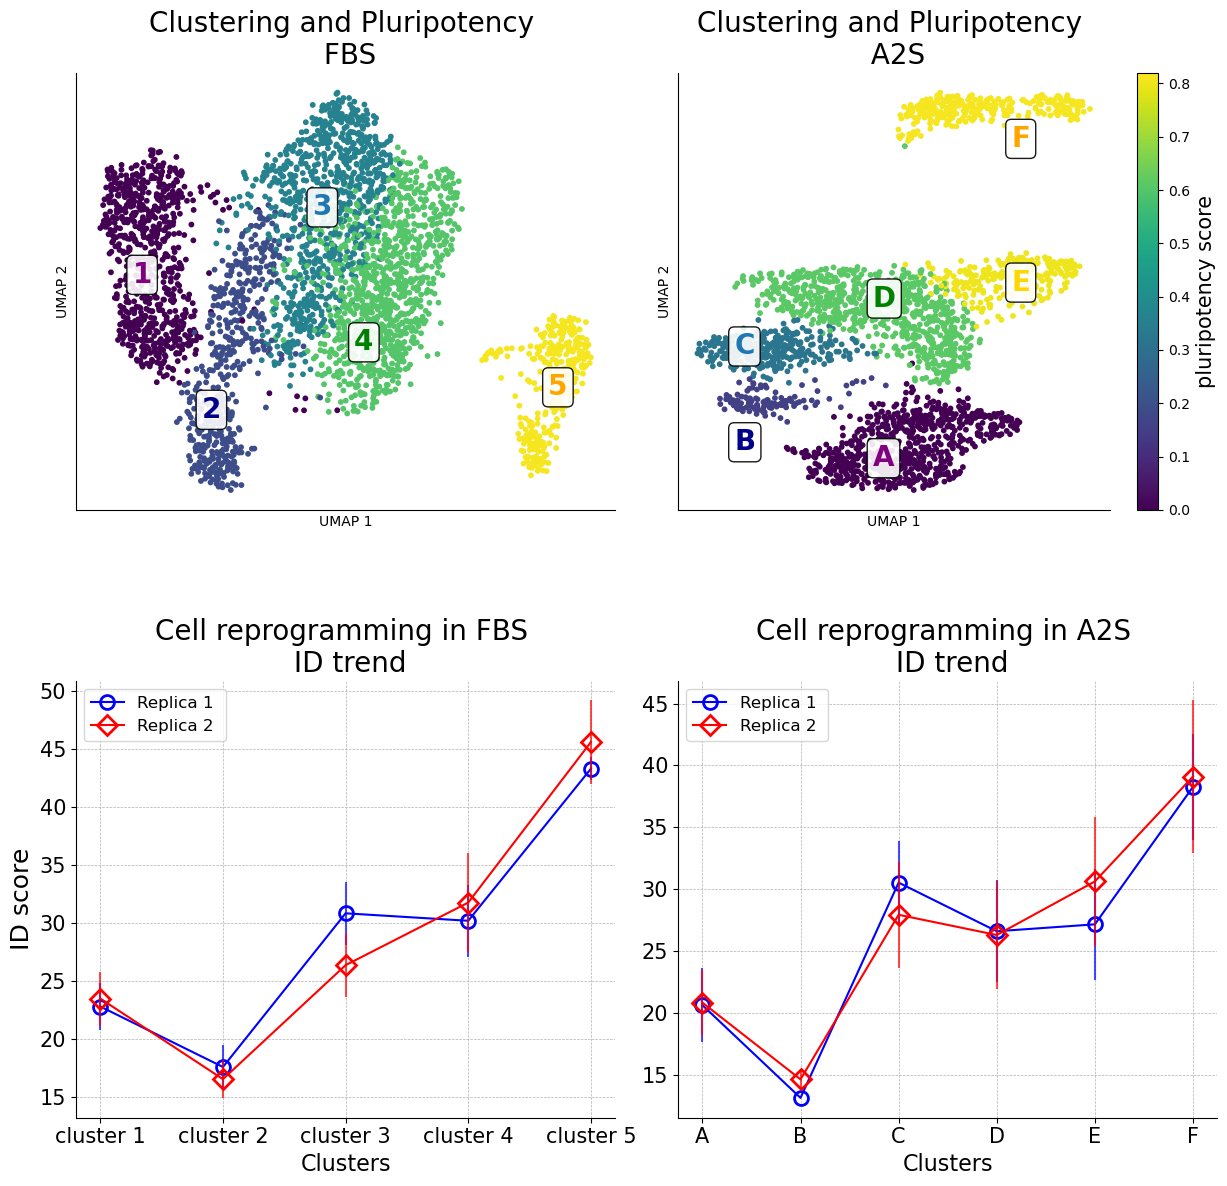

In [125]:
#create figure
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = axes.ravel()

#Colorbar
cmap = 'viridis'
norm = Normalize(vmin=0, vmax=0.82)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

# FBS clusters
umap_c_fbs = adata_fbs.obsm['X_umap']
axes[0].scatter(umap_c_fbs[:,0],umap_c_fbs[:,1], s=10, cmap = 'viridis', norm = norm, c = adata_fbs.obs.pluripotency.values)
axes[0].xaxis.set_ticks([])
axes[0].yaxis.set_ticks([])
axes[0].set_xlabel('UMAP 1')
axes[0].set_ylabel('UMAP 2')

axes[0].set_title('Clustering and Pluripotency \n FBS', fontsize=20)
sns.despine(ax=axes[0])

axes[0].text(3.,6.5,'1', fontweight = 'bold', fontsize = '20', 
             color = 'purple', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[0].text(5.5,3.5,'2',  fontweight = 'bold', fontsize = '20', 
             color = 'darkblue', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[0].text(9.5,8,'3',fontweight = 'bold', fontsize = '20', 
             color = 'tab:blue', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[0].text(11,5,'4', fontweight = 'bold', fontsize = '20', 
             color = 'green', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[0].text(18,4,'5', fontweight = 'bold', fontsize = '20', 
             color = 'orange', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))


# A2S clusters
umap_c_a2s = adata_a2s.obsm['X_umap']
axes[1].scatter(umap_c_a2s[:,0],umap_c_a2s[:,1], s=10, cmap = 'viridis', norm = norm, c = adata_a2s.obs.pluripotency.values)
axes[1].xaxis.set_ticks([])
axes[1].yaxis.set_ticks([])
axes[1].set_xlabel('UMAP 1')
axes[1].set_ylabel('UMAP 2')

axes[1].set_title('Clustering and Pluripotency \n A2S', fontsize=20)
sns.despine(ax=axes[1])

axes[1].text(10,-10,'A', fontweight = 'bold', fontsize = '20', 
             color = 'purple', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1].text(7,-9,'B',  fontweight = 'bold', fontsize = '20', 
             color = 'darkblue', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1].text(7,-3,'C',fontweight = 'bold', fontsize = '20', 
             color = 'tab:blue', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1].text(10,0,'D', fontweight = 'bold', fontsize = '20', 
             color = 'green', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1].text(13,1,'E', fontweight = 'bold', fontsize = '20', 
             color = 'gold', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))
axes[1].text(13,10,'F', fontweight = 'bold', fontsize = '20', 
             color = 'orange', bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='black', alpha=0.9))

cbar = fig.colorbar(sm, ax=axes[1], orientation='vertical')
cbar.set_label('pluripotency score', fontsize = 15)

#first subplot ID
axes[2].plot(col1, mean1, marker='o', markersize=10, markerfacecolor='none', markeredgewidth=2, color = 'blue', label=fr'Replica 1 ')
axes[2].errorbar(col1, mean1, yerr=std1,fmt=' ', alpha=0.7, color='blue')
axes[2].plot(col2, mean2,marker='D', markersize=10, markerfacecolor='none', markeredgewidth=2, color='red', label=fr'Replica 2 ')
axes[2].errorbar(col2, mean2, yerr=std2, fmt=' ', alpha=0.7, color='red')

axes[2].set_xlabel('Clusters', fontsize = 16)
axes[2].set_ylabel('ID score', fontsize = 18)
axes[2].set_title('Cell reprogramming in FBS \n ID trend', fontsize = '20')
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].tick_params(axis='both', which='major', labelsize=15)
sns.despine(ax=axes[2])
axes[2].legend(fontsize=12 , loc='upper left')


# Secondo subplot ID
axes[3].plot(col1_A, mean1_A, marker='o', markersize=10, markerfacecolor='none', markeredgewidth=2, color = 'blue', label=fr'Replica 1 ')
axes[3].errorbar(col1_A, mean1_A, yerr=std1_A,fmt=' ', alpha=0.7, color='blue')
axes[3].plot(col2_A, mean2_A,marker='D', markersize=10, markerfacecolor='none', markeredgewidth=2, color = 'red', label=fr'Replica 2 ')
axes[3].errorbar(col2_A, mean2_A, yerr=std2_A, fmt=' ', alpha=0.7, color='red')

axes[3].set_xlabel('Clusters', fontsize = 16)
axes[3].set_xticks(axes[3].get_xticks(), labels = ['A','B','C','D','E','F'])
axes[3].set_title('Cell reprogramming in A2S \n ID trend', fontsize = '20')
axes[3].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[3].tick_params(axis='both', which='major', labelsize=15)
sns.despine(ax=axes[3])
axes[3].legend(fontsize=12, loc='upper left')
#axes[3].set_ylim(axes[2].get_ylim()[0],axes[2].get_ylim()[1])


axes[0].set_position([0.1, 0.6, 0.35, 0.35])  # Top left
axes[1].set_position([0.55, 0.6, 0.45, 0.35])  # Bottom left (same size, could adjust for different size)
axes[2].set_position([0.05, 0.1, 0.40, 0.40])  # Top right
axes[3].set_position([0.525, 0.1, 0.425, 0.425])  # Bottom right



# Show plot
plt.tight_layout()
#plt.savefig('/Users/maddalenastaiano/Desktop/Plots/Tran_ID-UMAP_plots.png', dpi=900, bbox_inches='tight')
plt.show()